In [1]:
import os
import sys
import numpy as np
from astropy.io import fits as pf
from sklearn.neighbors import KernelDensity as kde
from scipy import integrate
import camb
from camb import model
from scipy.special import j0
from scipy import interpolate
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D as ax3d
from skmonaco import mcquad
from skmonaco import mcmiser
import time


In [12]:
#Import SpIES / SHELA data
data = '../Data_Sets/HZLZ_combined_all_wphotoz_alldata.fits'
obs = pf.open(data)[1].data
Z = obs.z
gdx = ((Z >= 2.9)&(Z <= 5.2) & (obs.dec>=-1.2) & (obs.dec<=1.2))
#gdx = ((Z >= 2.9)&(Z <= 3.4) & (obs.Good_obj == 0)) & (obs.dec>=-1.2) & (obs.dec<=1.2)
#gdx = ((Z >= 3.4)&(Z <= 5.2) & (obs.Good_obj == 0)) & (obs.dec>=-1.2) & (obs.dec<=1.2)

#gdx = Z>0
#Set up a KDE for dNdz
tmpz = Z[gdx][:, np.newaxis] #change the array from row shape (1) to column shape (1,)
print np.shape(tmpz)
sample_range = np.linspace(min(tmpz[:, 0]), max(tmpz[:, 0]), len(tmpz[:, 0]))[:, np.newaxis]

est = kde(bandwidth=0.05,kernel='epanechnikov') #Set up the Kernel

histkde = est.fit(tmpz).score_samples(sample_range) #fit the kernel to the data and find the density of the grid
#Interpolate (you get the same function back) to plug in any z in the range (as opposed to set z values)
dNdz = interpolate.interp1d(sample_range.flatten(),np.exp(histkde))
print sample_range.flatten()
print 'done'
ZE = np.linspace(min(Z),max(Z),100)
xo=integrate.quad(dNdz,min(sample_range),max(sample_range)) #quad(f(x),xlower,xupper, args)
print xo
print np.median(obs.z)
print np.mean(obs.z)
print np.max(obs.z)
print np.min(obs.z)

(1814, 1)
[ 2.9000001   2.90125216  2.90250423 ...,  5.16749594  5.16874801
  5.17000008]
done
(0.981778435486871, 0.0007240687874033869)
3.22807
3.38180269007
5.90000009537
2.90000009537


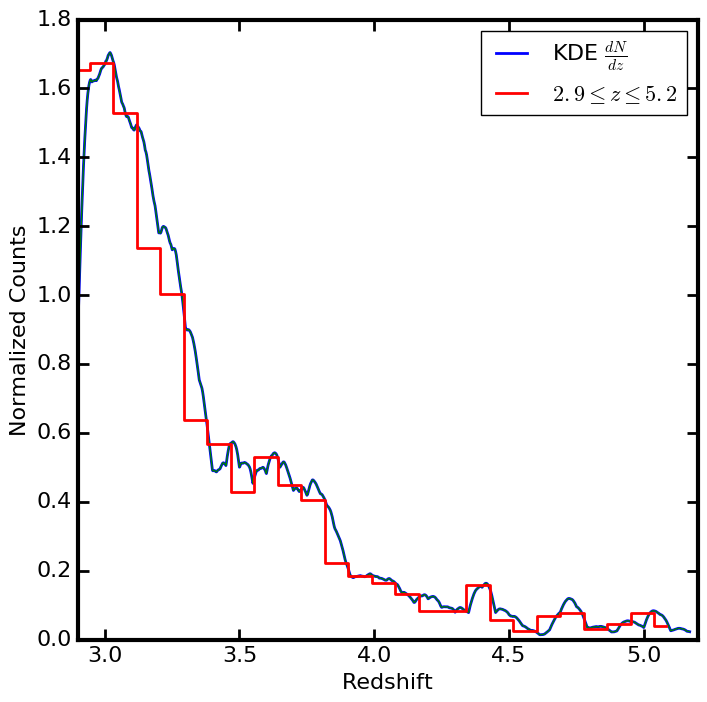

In [13]:
#Plotting Parameters (Replace with Group code call!)
params = {'legend.fontsize': 16, 'xtick.labelsize': 16, 'ytick.labelsize': 16, 'xtick.major.width':2, 'xtick.minor.width':2, 'ytick.major.width':2, 'ytick.minor.width':2, 'xtick.major.size':8, 'xtick.minor.size':6, 'ytick.major.size':8, 'ytick.minor.size':6}
plt.rcParams.update(params)
plt.rc("axes", linewidth=3.0)


num,bins = np.histogram(obs.z[gdx],bins='fd',normed=True)

#Compute the redshift percentiles for the Friedmann-Diaconis rule for bin width
#q75, q25 = np.percentile(obs.ZSPEC[gdx], [75 ,25])
#iqr = q75 - q25
#FD = 2*iqr /(len(obs.ZSPEC[gdx]))**(1/3.0)
#Set up the bin range from using the Friedmann Diaconis bin width
#bins = np.arange(min(obs.ZSPEC[gdx]),max(obs.ZSPEC[gdx]),FD)


#Plot the KDE dndz
plt.figure(1,figsize = [8,8])
plt.plot(sample_range[:,0],np.exp(histkde),linewidth = 2, label = r'KDE $\frac{dN}{dz}$')
plt.plot(sample_range[:,0],dNdz(sample_range[:,0]))
plt.plot(bins[:-1],num,linestyle = 'steps-mid',linewidth = 2, label=r'$2.9 \leq z \leq 5.2$')
#ZE = np.linspace(min(Z),max(Z),100)
#xo=integrate.quad(dNdz,min(sample_range),max(sample_range)) #quad(f(x),xlower,xupper, args)
#print xo
plt.xlim(2.9,5.2)
plt.xlabel('Redshift',fontsize = 16)
plt.ylabel('Normalized Counts',fontsize = 16)
plt.legend()
#plt.savefig('dndz.pdf')
plt.show() 

In [29]:
# Compute the matter power spectrum from CAMB and Generate the P(z,k) function to output the power at any given redshift
#and wavenumber

#First define Planck 2015 cosmological parameters
H = 70 #H0. 
oc = 0.229 #physical density of CDM 
ob = 0.046 #physical density of baryons

#Conversion to density param: Omega_Matter = (oc+ob)/(H0/100.)**2

#Set up parameters in CAMB
pars = camb.CAMBparams()
#H0 is hubble parameter at z=0, ombh2 is the baryon density (physical), omch2 is the matter density (physical)
#mnu is sum of neutrino masses, omk is curvature parameter (set to 0 for flat), meffsterile is effective mass of sterile neutrinos
#pars.set_cosmology(H0=H,ombh2=ob, omch2=oc,omk=0)#,mnu=0,meffsterile=0) 

#Hard code the cosmolgy params
pars.H0=H #hubble param (No h!!)
pars.omegab=ob #Baryon density parameter
pars.omegac=oc #CDM density parameter
pars.omegav=0.725 #Vacuum density parameter
pars.set_dark_energy()

#Set parameters using standard power law parameterization.If nt=None, uses inflation consistency relation.
#ns is scalar speectral index
pars.InitPower.set_params(ns=0.960)
camb.set_halofit_version(version='original') #uses the Smith 2003 halo model
ze=np.linspace(0,20,150)
ka=np.logspace(-4,2,len(ze))#np.linspace(0,10,100)
#Get the matter power spectrum interpolation object (based on RectBivariateSpline). 
#pars: input parameters, zs: redshift range, nonlinear: generate nonlinear power spectrum, hubble_units=True: output as Mpc/h^3 
#instead of Mpc^3 
PK = camb.get_matter_power_interpolator(pars,zs = ze,zmax = ze[-1], nonlinear=True, hubble_units=True, k_hunit=True, kmax = ka[-1])
PK2 = camb.get_matter_power_interpolator(pars,zs = ze,zmax = ze[-1], nonlinear=True, hubble_units=False, k_hunit=False, kmax = ka[-1])

#Generate the power using the interpolator and the z and k arrays
#Power = PK.P(z,k)